# Import libraries

In [1]:
# Libraries needed to run the tool
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_PATH = Path("data")
DATA_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH = Path("figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Initialize data

In [3]:
# read file with original dataset to get values for minmax scaling
harv_name = "harvesting_data.xlsx"
harv = pd.read_excel(Path.joinpath(DATA_PATH, harv_name), header=0)
water = harv["Water_volume"]
harv = harv.drop(columns=["Water_volume"], axis=1)
minval = harv.min()
minmax = harv.max() - harv.min()
minval_water = water.min()
minmax_water = water.max() - water.min()

# read file with operating conditions for the simulation
sim_name = "simulation_data.xlsx"
data = pd.read_excel(Path.joinpath(DATA_PATH, sim_name), header=0)
time = data["Time"]
temp = data["Temperature"]
rh = data["RH"]
data = data.drop(columns=["Time"], axis=1)

data_scaled = (data - minval) / minmax

# Prediction

In [4]:
# ask for model to use
name = input("Model to use for prediction (gbr, mlp, svr): \n")

if name == "gbr":
    model = pickle.load(open(Path.joinpath(MODELS_PATH, "gbm.pkl"), "rb"))

if name == "mlp":
    model = pickle.load(open(Path.joinpath(MODELS_PATH, "nn.pkl"), "rb"))

if name == "svr":
    model = pickle.load(open(Path.joinpath(MODELS_PATH, "svr.pkl"), "rb"))

results_scaled = model.predict(data_scaled)

# unscale the predicted values
results = (results_scaled * minmax_water + minval_water) * 60 / 50

cumulative = np.zeros(len(results))

for i in range(1, len(results)):
    cumulative[i] = cumulative[i - 1] + results[i - 1]

# Produce plot

C:\Users\giulio.barletta\AppData\Local\Temp\ipykernel_2112\3767873365.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for label in ax.set_xticklabels(time, rotation="vertical", size=15)[1::2]:


<function matplotlib.pyplot.show(close=None, block=None)>

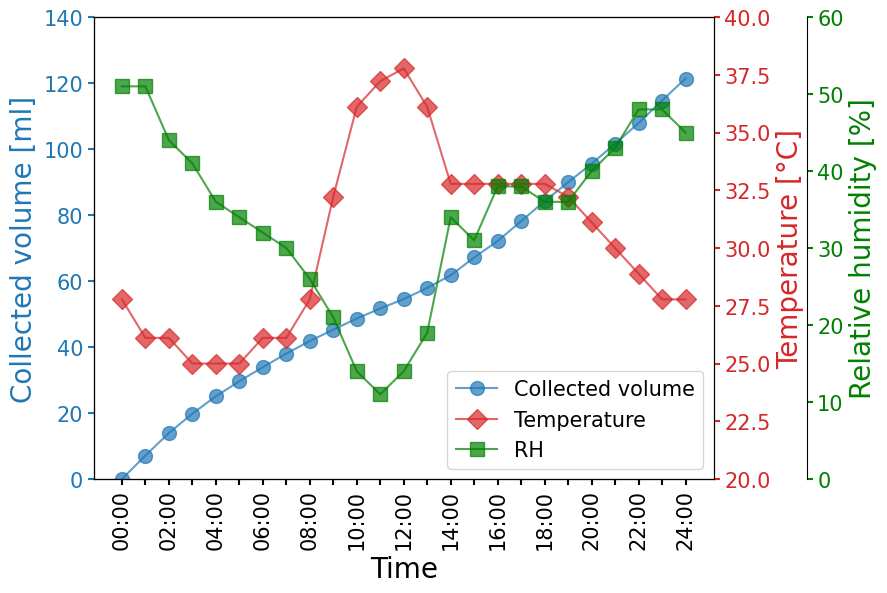

In [6]:
time = [f"{hour:02d}:00" for hour in range(25)]
time_label = [f"{hour:02d}:00" for hour in range(25)]
for i in range(1, len(time), 2):
    time_label[i] = " "

plt.rcParams.update({"figure.figsize": [8, 6], "lines.markersize": 10.0})
fig, ax = plt.subplots()
twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.15))

(p1,) = ax.plot(
    time, cumulative, "o-", c="tab:blue", label="Collected volume", alpha=0.7
)
(p2,) = twin1.plot(time, temp, "D-", c="tab:red", label="Temperature", alpha=0.7)
(p3,) = twin2.plot(time, rh, "s-", c="g", label="RH", alpha=0.7)

ax.set_ylim(0, 140)
twin1.set_ylim(20, 40)
twin2.set_ylim(0, 60)

ax.set_xlabel("Time", size=20)
for label in ax.set_xticklabels(time, rotation="vertical", size=15)[1::2]:
    label.set_visible(False)
ax.set_ylabel("Collected volume [ml]", size=20)
twin1.set_ylabel("Temperature [°C]", size=20)
twin2.set_ylabel("Relative humidity [%]", size=20)
ax.tick_params(axis="both", which="major", labelsize=15)
twin1.tick_params(axis="both", which="major", labelsize=15)
twin2.tick_params(axis="both", which="major", labelsize=15)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis="y", colors=p1.get_color(), **tkw)
twin1.tick_params(axis="y", colors=p2.get_color(), **tkw)
twin2.tick_params(axis="y", colors=p3.get_color(), **tkw)
ax.tick_params(axis="x", **tkw)

ax.legend(handles=[p1, p2, p3], loc="lower right", fontsize=15)

plt.savefig(Path.joinpath(FIGURES_PATH, "simulation.svg"), bbox_inches="tight", dpi=600)
plt.show